In [2]:
import os
os.environ["COHERE_API_KEY"] = 'E2efronXbGqXSR0sclyInSjXptFOjdIjsbCeXFwP'

import pandas as pd
from tqdm.notebook import tqdm

from langchain_cohere import ChatCohere
from langchain_ollama import ChatOllama

from langchain_core.prompts import ChatPromptTemplate
from langchain_pymupdf4llm import PyMuPDF4LLMLoader

from pydantic import BaseModel, Field, constr
from typing import Literal, List, Optional

In [3]:
XL_PATH = r"../dataset/screening/articles_to_screen.csv"
OUT_DIR = r"results"
if not os.path.exists(OUT_DIR):
    os.makedirs(OUT_DIR)

In [4]:
# screened abstracts

df = pd.read_csv(XL_PATH)[["key", "title", "abstract"]]

display(df.head())
print(len(df))

,key,title,abstract
0,rayyan-97865221,Responsive Magnetic Particle Imaging Tracer: O...,Magnetic particle imaging (MPI) has emerged as...
1,rayyan-97865222,"The role of apoptosis, immunogenic cell death,...","Keloids, characterized by excessive extracellu..."
2,rayyan-97865224,"Particle tracking, recognition and LET evaluat...",Objective. This study aims to assess the compo...
3,rayyan-97865227,Understanding Relative Biological Effectivenes...,Purpose: Recent experimental studies and clini...
4,rayyan-97865228,Use of parvovirus B19-like particles in self-i...,Bioluminescence resonance energy transfer phot...


413


In [5]:
class OutputSchema(BaseModel):
    thoughts: str = Field(description= "thoughts of the model")
    decision: int = Field(description="1 if the article is SELECTED as it falls with the scope of the REVIEW_TOPIC, 0 otherwise")
    reason: str = Field(description = "generate a consise one sentence long reason for the decision")
    ai_method_list: Optional[List[str]] = Field(default=None, description="list all the AI method explored in the article")


# llm = ChatCohere(model="command-r", temperature=0.0)
llm = ChatOllama(model="deepseek-r1:32b", temperature=0.0, num_ctx=5_000)
struct_llm = llm.with_structured_output(OutputSchema)

In [ ]:
# messages = [
#     ('system',  "You are a helpful AI agent that assists in accurately screening the article using its abstract. " 
#                 "Based solely on the abstract provided, determine whether the article discusses an APPLICATION OF AI METHODS IN CARBON ION THERAPY? "
#                 "Your decision should be '0' for NO or '1' for YES. Then, generate a concise, one-sentence reason for your decision."
#     ),
#     ('human', "abstract:\n\n title: {title}, \n content: {abstract}")
#   ]

messages = [
    ('system',  "You are a helpful AI reviewer that ACCURATELY SCREENS and SELECTS 'ORIGINAL RESEARCH ARTICLES' that falls within the scope of the given 'LITERATURE_REVIEW_TOPIC', based on their ABSTRACT." 
                "Your decision should be '1' if SELECTED or '0' otherwise."
                "Generate a concise, one-sentence reason to motivate your decision."
                "If selected, list all the AI methods explored in the ORIGINAL RESEARCH ARTICLE."
    ),
    ('human', "ABSTRACT:\n\n title: {title}, \n content: {abstract}\n\n LITERATURE_REVIEW_TOPIC: APPLICATIONS OF AI IN CARBON ION THERAPY")
  ]

prompt_template = ChatPromptTemplate.from_messages(messages)
chain = prompt_template | struct_llm

decision_df = {"key":[], "title":[], "abstract":[], "decision":[], "ai_method_list":[], "reason":[], "thoughts":[]}

rows = [row.to_dict() for i,row in df.iterrows()]

for row in tqdm(rows):
  # key, title, selection = row.to_dict()["key"], row.to_dict()["title"], row.to_dict()["selection"]

  inputs = {key:row[key] for key in ["title", "abstract"]} 

  output = chain.invoke(inputs)

  for key,val in {**row, **dict(output)}.items():
      decision_df[key].append(val)
  
decision_df = pd.DataFrame(decision_df)
if not os.path.exists(OUT_DIR):
   os.makedirs(OUT_DIR)
decision_df.to_csv(os.path.join(OUT_DIR, "ai_decision_new.csv"), index=False)


  0%|          | 0/413 [00:00<?, ?it/s]

KeyError: 'ai_method_list'

In [24]:
decision_df = pd.read_csv("results/ai_decision.csv")

In [26]:
len(decision_df[decision_df.decision==1])

30

In [ ]:
# generating summaries

In [ ]:
# this doesn't work very well
# from langchain_community.document_loaders import PyPDFLoader


# file_path = r"1-s2.0-S1120179724002163-main.pdf"
# loader = PyPDFLoader(file_path, mode='single')
# pages = []
# async for page in loader.alazy_load():
#     pages.append(page)

# manuscript = "\n".join([page.page_content for page in pages])

In [ ]:
# import pymupdf4llm

# file_path = r"1-s2.0-S1120179724002163-main.pdf"
# manuscript = pymupdf4llm.to_markdown(file_path)

# ref_index = manuscript.lower().find("references")

# # Keep everything up to and including "References"
# if ref_index != -1:
#     manuscript = manuscript[:ref_index + len("references")]

# # Now md_text contains only up to the References section
# print(manuscript)

In [ ]:

# class OutputSchema(BaseModel):
#     thoughts: str = Field(description= "thoughts of the model")
#     study_objective: str = Field(description="The objective of the article")
#     ai_methods: str = Field(description="The AI method(s) used in the article in the context of carbon ion therapy. Describe each AI method at least in one sentence")
#     application_domain: str = Field(description="the specific carbon ion therapy application domain")
#     dataset_characteristics: str = Field(description="characteristics of the dataset, including the training, validation, test split; also external validation information, if present")
#     key_findings: str = Field(description="key findings mentioned in the article")
#     pros_and_cons: str = Field(description="strengths and limitations of the study")
#     future_direction: str = Field(description="future directions (if stated)")

# llm = ChatCohere(model='command-r', temperature=0.0)
# # llm = ChatOllama(model="deepseek-r1:32b", temperature=0.0)
# struct_llm = llm.with_structured_output(OutputSchema)

# messages = [
#     ('system',  "You are a helpful AI agent that assists in accurately summarizing the article in a standardized format "
#                 "to be used for the literature review titled 'APPLICATIONS OF AI IN CARBON ION THERAPY'. \n"
#                 "Summarize the article under the following standard headers:\n"
#                 "'1. Study objective', '2. AI methods used', '3. carbon therapy application domain', '4. Dataset characteristics', '5. Key findings', "
#                 "'6. Strengths and limitations', '7. Future directions (if stated)' "
#     ),
#     ('human', "article: \n {article}")
#   ]

# prompt_template = ChatPromptTemplate.from_messages(messages)
# chain = prompt_template | struct_llm


In [7]:
import seaborn, wordcloud
print(seaborn.__version__, wordcloud.__version__)

0.13.2 1.9.4


In [13]:

class OutputSchema(BaseModel):
    thoughts: str = Field(description="thoughts of the model")
    aim: str = Field(description="answer to q1: aim of the research article")
    category: Literal["Treatment planning, optimization and verification",
        "Synthetic imaging",
        "Tumor control probability (TCP) prediction",
        "Normal tissue complication probability (NTCP) prediction"] = Field(description="answer to q2: article category selected from the predefined LIST")
    dataset: str = Field(description="answer to q3: dataset description and the strategy associated with training, validation and test involved in AI modelling. Also provide the sample counts associated with the train, val and test set.")
    ai_methodology: str = Field(description="answer to q4: the AI methodology used by the authors for their analysis")
    ai_method_list: List[str] = Field(description="followup answer to q4: list of ai methodologies used by the authors for their analysis")
    pros_and_cons: str = Field(description="answer to q5: the strengths and weaknesses of the methodology followed")
    results: str = Field(description="answer to q6: summary of the results in terms of the performance metrics and the appropriateness of the metrics were to evaluate the AI model.")
    arguments: str = Field(description="answer to q7: the strong and weak arguments that the authors are pointing out in the discussion")
    conclusion: str = Field(description="answer to q8. their conclusion, and main arguments to support it")
    critical_summary: str = Field(description="a critical summary combining the answers for q1-q8")
    short_summary: constr(max_length=300) = Field(description="a concise critical summary limited 300 characters, including spaces")
    

# llm = ChatCohere(model='command-r', temperature=0.0)
llm = ChatOllama(model="deepseek-r1:32b", temperature=0.0, num_ctx=15_000)
struct_llm = llm.with_structured_output(OutputSchema)

In [ ]:
# from transformers import AutoTokenizer

# import json
# schema_str = json.dumps(OutputSchema.model_json_schema())
# tokenizer = AutoTokenizer.from_pretrained("deepseek-ai/DeepSeek-R1-Distill-Qwen-32B")
# len(tokenizer.encode(schema_str))

In [14]:
system_message = ''''
You are an expert AI reviewer tasked to perform a concise yet accurate literature review of the provided ARTICLE for the specified REVIEW_TOPIC.
Carefully read the entire ARTICLE (exluding the abstract) and generate a CRITICAL_SUMMARY and a SHORT_SUMMARY by accurately answering each of the QUESTIONS below.

QUESTIONS:
q1. What is the aim of this study?
q2. Select the single most appropriate category for the article from the LIST below.
    LIST:
    - Treatment planning, optimization and verification
        Focus: processes before treatment delivery, such as dose prediction, treatment planning, plan optimization, dose calculation, and plan verification.
    - Synthetic imaging
        Focus: generating or transforming images for treatment planning or dose delivery.
    - Tumor control probability (TCP) prediction
        Focus: modeling tumor response to treatment.
    - Normal tissue complication probability (NTCP) prediction
        Focus: adverse events, toxicities, complications, or quality-of-life after treatment.
    **Selection Rules:**
    i. If the study fits multiple categories, select the one explicitly stated as the primary endpoint.
    ii. If no primary endpoint is stated, choose the category most emphasized in the title and/or aim.
    iii. The answer must be exactly one element from the LIST above.
    iv. Do not include reasoning or deliberation in the answer. Only output the category name.

q3. Describe the dataset and provide the training, validation and test strategy involved in AI modelling, including the corresponding sample counts.
q4. Define the AI methodology used by the authors for their analysis and generate a list of ai methods that they explored.
q5. What are the strengths and weaknesses of the methodology followed?
q6. Can you summarize the results in terms of the performance metrics and assess whether the authors chose appropriate metrics to evaluate the AI model?
q7. What are the strong and weak arguments that the authors are pointing out in the discussion?
q8. What is their conclusion, and what are their main arguments to support it?

Answer each question accurately using the information directly available in the ARTICLE. 
If specific information required to answer any question is not present in the ARTICLE, state this clearly instead of speculating.
The ANSWERS should be detailed, evidence-based and written in an objective and academic tone appropriate for a scientific literature review. 

The CRITICAL_SUMMARY should integrate the answers to q1-q8 into a coherent, structured review.
The SHORT_SUMMARY should be a compressed version of CRITICAL_SUMMARY, limited to 300 characters (including spaces).
'''

human_message = "ARTICLE:\n{article}\n\nREVIEW_TOPIC:{topic}"

In [15]:
messages = [
    ('system', system_message),
    ('human', human_message)
]

prompt_template = ChatPromptTemplate.from_messages(messages)
chain = prompt_template | struct_llm

In [16]:
import re

In [17]:
outputs = []

trend_df = pd.read_excel("trend_table.xlsx")

for i,row in tqdm(list(trend_df.iterrows())):

    row_dict = row.to_dict()

    file_path = row_dict['path']

    loader = PyMuPDF4LLMLoader(file_path, mode='single') #we are loading all the pages of the documents in a single page
    docs = loader.load()
    manuscript = docs[0].page_content

    # Keep everything except contents inside "References"
    pattern = re.compile(r'^[#\*\s]*references\b', re.IGNORECASE | re.MULTILINE)
    match = pattern.search(manuscript)
    if match:
        ref_index = match.start()
        manuscript = manuscript[:ref_index + len(match.group(0))]

  

    output = dict(chain.invoke({"article":manuscript, "topic":"APPLICATIONS OF AI IN CARBON ION THERAPY"}))
    output["file_path"] = file_path

    output = {**row_dict, **output}

    print(output["category"], file_path, output['aim'])

    outputs.append(output)

  


  0%|          | 0/19 [00:00<?, ?it/s]

Synthetic imaging selected_articles/Zhang_DR_only_CIRT_TPS_DL_PhyMed_2022.pdf To evaluate the feasibility of using deep learning to generate synthetic CT images from DR images for carbon ion therapy treatment planning, reducing the need for multiple CT scans and associated radiation exposure.
Synthetic imaging selected_articles/Parrella_SyntCT_CIRT_Abdomen_Bioeng_2023.pdf The aim of this study is to evaluate the feasibility of generating synthetic CT (sCT) volumes using a conditional generative adversarial network (cGAN) for carbon ion radiotherapy (CIRT) applications in the abdominal site, enabling an MRI-only workflow for treatment planning and adaptation without additional ionizing radiation.
Synthetic imaging selected_articles/Knausl_synthetic_CT_in_adapative_CIRT.pdf The aim of this study is to explore the potential and challenges of using synthetic computed tomography (sCT) derived from MRI in carbon-ion therapy treatment planning. The authors seek to evaluate whether sCT can rep

In [18]:
pd.DataFrame(outputs).to_csv(os.path.join("results/ai_review_final.csv"), index=False)

In [20]:
pd.DataFrame(outputs)["ai_method_list"]

0                            [CycleGAN, DRR-CT Network]
1     [Three-channel cGAN, Conditional GAN (cGAN), P...
2         [3D U-Net, ResNet blocks, feature-based loss]
3                                            [CycleGAN]
4                    [Conditional GAN, U-Net, PatchGAN]
5     [Radiomic features extraction, L2-penalized lo...
6     [Random Survival Forest, Cox Proportional Haza...
7                                        [s-SVM, r-Cox]
8            [r-Cox, s-SVM, Mann-Whitney U test, LASSO]
9     [Regularized Cox proportional hazard model, Su...
10    [Logistic Regression, Decision Tree Analysis (...
11    [Logistic Regression, Receiver Operating Chara...
12    [Logistic Regression, Lasso Regression, Decisi...
13    [Logistic Regression, LASSO Regression, Stepwi...
14    [U-Net, convolutional layers, batch normalizat...
15                        [CycleGAN, 3DUNet, GhostUNet]
16                        [P-Net, Custom Loss Function]
17    [CAM-CHD U-Net, Channel Attention Mechanis

/tmp/ipykernel_2003774/2963213266.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.96])


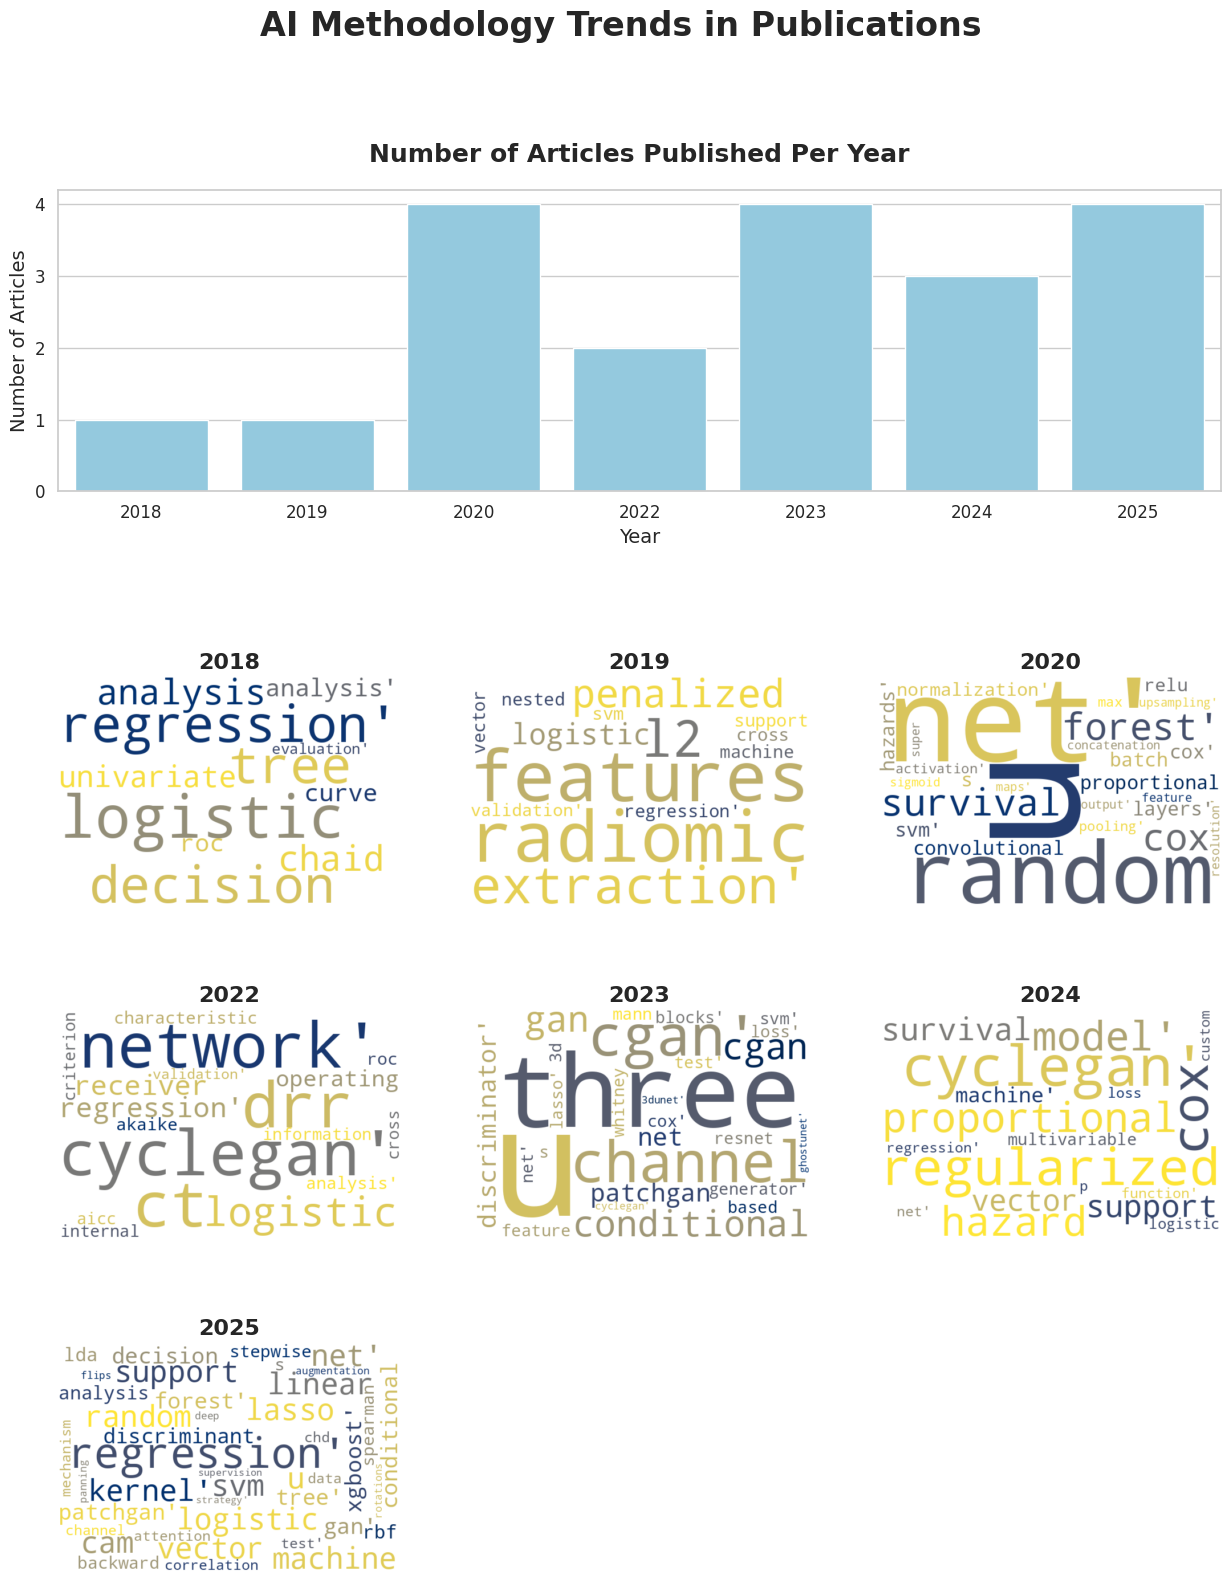

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from wordcloud import WordCloud
import seaborn as sns
import re
import math

# --- User Configuration ---
CSV_FILE_PATH = 'results/ai_review_final.csv'
# Add more stop words to this set to exclude them from the word cloud
STOP_WORDS = set(['the', 'and', 'to', 'of', 'a', 'in', 'for', 'with', 'is', 'on', 'an', 'by', 'as', 's', 'are', 'from', 'we', 'that', 'it', 'were', 'was', 'have', 'been', 'this', 'at', 'can', 'be', 'used', 'using', 'based', 'model', 'data', 'method'])

def generate_vertical_wordcloud_plot(file_path):
    """
    Reads a CSV and generates a top-and-bottom plot with publication trends
    and yearly AI methodology word clouds.
    """
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found.")
        print("Please ensure the CSV file is in the same directory or provide the full path.")
        return

    # --- Data Preparation ---
    df['Year of pubblication'] = pd.to_numeric(df['Year of pubblication'], errors='coerce').dropna()
    df['Year of pubblication'] = df['Year of pubblication'].astype(int)
    yearly_counts = df['Year of pubblication'].value_counts().sort_index()
    years = sorted(df['Year of pubblication'].unique())

    # --- Plotting Setup ---
    sns.set(style="whitegrid", font_scale=1.1)
    fig = plt.figure(figsize=(15, 18))
    # Create a GridSpec layout: 2 main rows. Top is for the bar chart, bottom for word clouds.
    gs_main = gridspec.GridSpec(2, 1, figure=fig, height_ratios=[1, 3], hspace=0.3)

    # --- Top Panel: Number of Articles per Year ---
    ax_top = fig.add_subplot(gs_main[0])
    sns.barplot(x=yearly_counts.index, y=yearly_counts.values, ax=ax_top, color='skyblue')
    ax_top.set_title('Number of Articles Published Per Year', fontsize=18, weight='bold', pad=20)
    ax_top.set_xlabel('Year', fontsize=14)
    ax_top.set_ylabel('Number of Articles', fontsize=14)
    ax_top.tick_params(axis='x', rotation=0)

    # --- Bottom Panel: Yearly Word Clouds ---
    # Create a nested GridSpec for the word clouds
    cols = 3 # Number of columns for word clouds
    rows = math.ceil(len(years) / cols)
    gs_bottom = gridspec.GridSpecFromSubplotSpec(rows, cols, subplot_spec=gs_main[1], hspace=0.4, wspace=0.2)

    for i, year in enumerate(years):
        ax = fig.add_subplot(gs_bottom[i])
        year_df = df[df['Year of pubblication'] == year]
        text = " ".join(review for review in year_df.ai_method_list.dropna()).lower()

        if text.strip():
            wordcloud = WordCloud(
                width=600,
                height=400,
                background_color="white",
                colormap='cividis'#colormap="Reds"
            ).generate(text)
            # wordcloud = WordCloud(
            #     width=400, height=200, background_color='white',
            #     stopwords=STOP_WORDS, colormap='cividis', max_words=40
            # ).generate(text)
            ax.imshow(wordcloud, interpolation='bilinear')
            ax.set_title(str(year), fontsize=16, weight='bold')
        else:
            ax.text(0.5, 0.5, 'No Data', ha='center', va='center', fontsize=12)
            ax.set_title(str(year), fontsize=16, weight='bold')

        ax.axis('off')

    # Hide any unused subplots in the bottom grid
    for i in range(len(years), rows * cols):
        fig.add_subplot(gs_bottom[i]).axis('off')

    fig.suptitle('AI Methodology Trends in Publications', fontsize=24, weight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig('vertical_wordcloud_plot.png', dpi=300)
    plt.show()

if __name__ == '__main__':
    generate_vertical_wordcloud_plot(CSV_FILE_PATH)

findfont: Font family ['DejaVuSans'] not found. Falling back to DejaVu Sans.


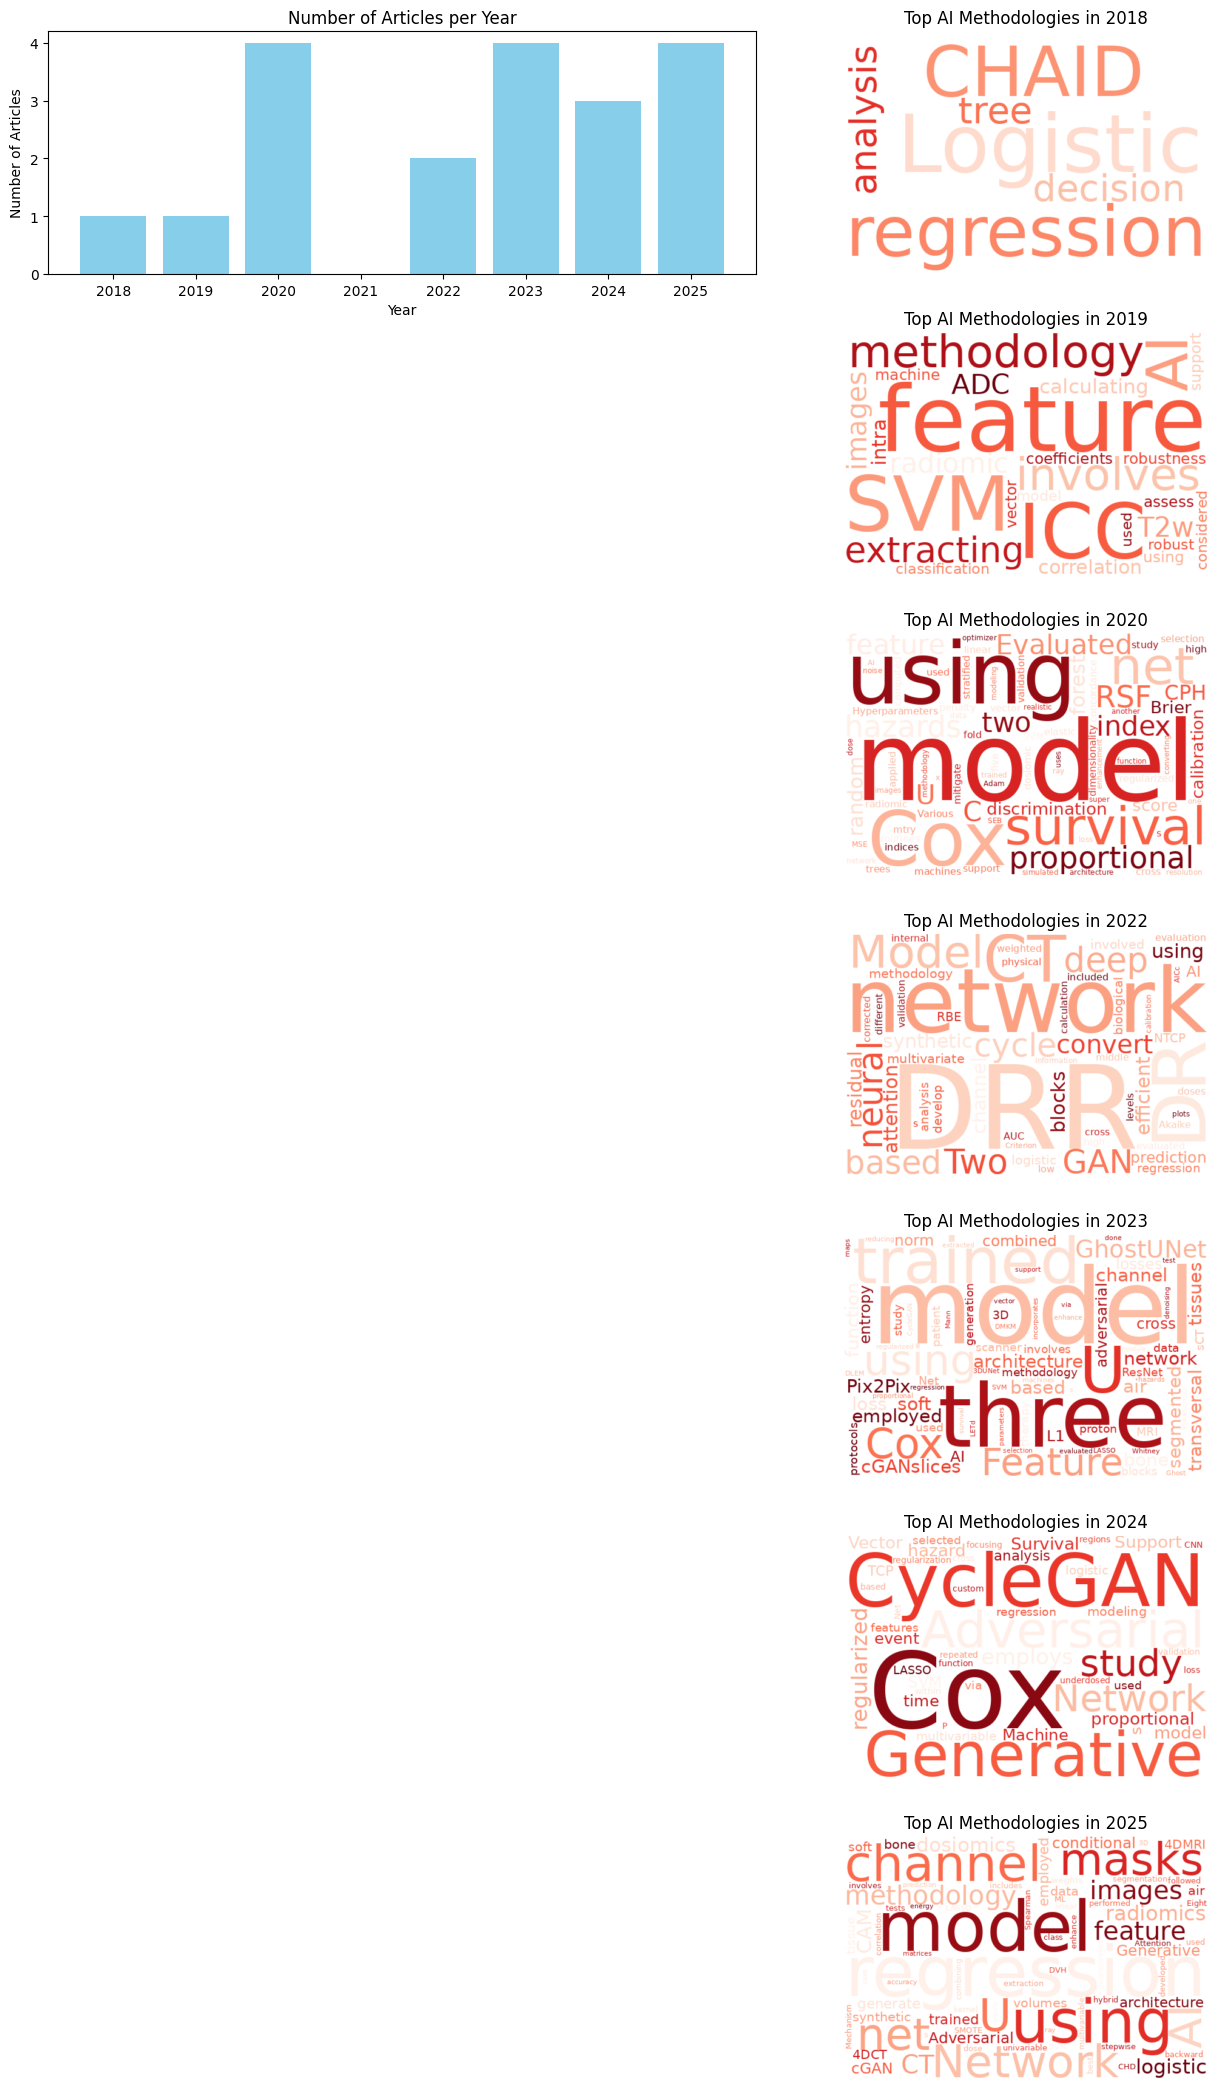

In [102]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from matplotlib import font_manager

# Load your CSV
df = pd.read_csv("results/ai_review_new.csv")

# Group AI methodologies by year
year_methodologies = df.groupby("Year of pubblication")["ai_methodology"].apply(lambda x: " ".join(x.astype(str)))

# Get available years
years = sorted(year_methodologies.index.unique())
n_years = len(years)

# Use matplotlib's built-in DejaVuSans font
font_path = font_manager.findfont("DejaVuSans")

# Create grid layout
fig, axes = plt.subplots(n_years, 2, figsize=(14, 3 * n_years))

# Plot trend (articles per year) on the top-left panel
article_counts = df["Year of pubblication"].value_counts().sort_index()
axes[0, 0].bar(article_counts.index, article_counts.values, color="skyblue")
axes[0, 0].set_title("Number of Articles per Year")
axes[0, 0].set_xlabel("Year")
axes[0, 0].set_ylabel("Number of Articles")

# Remove unused left-side axes (except the first one used for trend)
for i in range(1, n_years):
    axes[i, 0].axis("off")

# Generate word clouds for each year
for i, year in enumerate(years):
    text = year_methodologies[year]
    wc = WordCloud(
        width=600,
        height=400,
        background_color="white",
        colormap="Reds",
        font_path=font_path
    ).generate(text)
    
    axes[i, 1].imshow(wc, interpolation="bilinear")
    axes[i, 1].axis("off")
    axes[i, 1].set_title(f"Top AI Methodologies in {year}")

plt.tight_layout()
plt.show()


In [88]:
output

{'Title': 'Unsupervised Deep Learning for Synthetic CT Generation from CBCT Images for Proton and Carbon Ion Therapy for Paediatric Patients',
 'Authors': 'Pepa et al',
 'Journal': 'Sensors',
 'Year of pubblication': 2024,
 'path': 'selected_articles/Pepa_syntheticCT from CBCT.pdf',
 'thoughts': "Okay, so the user provided a detailed article about using CycleGAN to generate synthetic CT scans from CBCT images for adaptive particle therapy. They want me to summarize this in the context of applications of AI in carbon ion therapy. Hmm, let's break this down. The study focuses on improving image quality for treatment adaptation, which is crucial because carbon ions are sensitive to anatomical changes. I need to highlight how AI, specifically CycleGAN, helps here. Also, the target audience might be professionals in radiation oncology or medical physics, so I should keep it technical but clear. They mentioned limitations like small sample size and lack of ground truth, which are important p

In [17]:
outputs = []

ARTICLE_DIR = r"selected_articles"

file_paths = [os.path.join(ARTICLE_DIR, file) for file in os.listdir(ARTICLE_DIR) if file.endswith(".pdf")]

outputs = []

for file_path in tqdm(file_paths):
    loader = PyMuPDF4LLMLoader(file_path, mode='single') #we are loading all the pages of the documents in a single page
    docs = loader.load()
    manuscript = docs[0].page_content

    # Keep everything except contents inside "References"
    pattern = re.compile(r'^[#\*\s]*references\b', re.IGNORECASE | re.MULTILINE)
    match = pattern.search(manuscript)
    if match:
        ref_index = match.start()
        manuscript = manuscript[:ref_index + len(match.group(0))]

  

    output = dict(chain.invoke({"article":manuscript, "topic":"APPLICATIONS OF AI IN CARBON ION THERAPY"}))
    output["file_path"] = file_path

    print(output["category"], file_path, output['aim'])

    outputs.append(output)




  0%|          | 0/18 [00:00<?, ?it/s]

Normal tissue complication probability (NTCP) prediction selected_articles/Zhang_Predicting_Weight_Loss_PT_2018_JJCO.pdf The aim of this study is to investigate the predictors of critical weight loss in cancer patients undergoing particle therapy and develop a prediction model based on these factors.
Synthetic imaging selected_articles/Parrella_SyntCT_CIRT_Abdomen_Bioeng_2023.pdf The aim of this study is to evaluate the feasibility of using a conditional generative adversarial network (cGAN) to generate synthetic CT (sCT) images for carbon ion radiotherapy (CIRT) in abdominal sites, enabling MRI-only workflows without additional radiation exposure. The study focuses on improving treatment planning accuracy by addressing inter-acquisition motion and anatomical discrepancies between CT and MRI scans.
Treatment planning, optimization and verification selected_articles/Zhang_DL_Denoising_MC_DoseCalculationCIRT_MP_2023.pdf The aim of this study is to evaluate the feasibility of using deep l

In [ ]:
pd.DataFrame(outputs).to_csv(os.path.join("results/ai_review_new.csv"), index=False)

: 

In [ ]:
# from fpdf import FPDF


# def clean_text(text):
#     return text.encode('latin-1', errors='replace').decode('latin-1')

# # Create PDF
# pdf = FPDF()
# pdf.add_page()
# pdf.set_font("Arial", size=12)


# for heading, text in output.items():
#     # Add heading
#     pdf.set_font("Arial", 'B', 14)
#     pdf.cell(0, 10, heading, ln=True)
    
#     # Add text
#     pdf.set_font("Arial", size=12)
#     pdf.multi_cell(0, 10, clean_text(text))
#     pdf.ln(5)  # Add some space

# pdf.output(os.path.join("results", "output.pdf"))

In [ ]:
# from transformers import pipeline, AutoConfig
# from langchain_huggingface import HuggingFacePipeline, ChatHuggingFace
# from langchain_core.prompts import PromptTemplate

# model_name = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B" #"deepseek-ai/DeepSeek-R1-Distill-Qwen-32B"

# config = AutoConfig.from_pretrained(model_name)
# pipe = pipeline("text-generation", model=model_name, max_new_tokens=2048, device=1, do_sample=False) #temperature = 0.0 since do_sample is False
# llm = HuggingFacePipeline(pipeline=pipe)


# # print(config)
